In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score ,precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt


In [3]:
#  Load data
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [6]:
def impute_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputes missing values:
    - For categorical columns: replace with 'NA'
    - For numerical columns: replace with 0.0
    """
    df_copy = df.copy()
    
    print("\n🔹 Before imputation:")
    print(df_copy.isnull().sum()[df_copy.isnull().sum() > 0])
    
    for col in df_copy.columns:
        if df_copy[col].dtype == 'object':
            df_copy[col] = df_copy[col].fillna('NA')
        else:
            df_copy[col] = df_copy[col].fillna(0.0)
    
    print("\n✅ After imputation (should show 0 missing values):")
    print(df_copy.isnull().sum().sum(), "missing values remaining\n")
    
    return df_copy

In [7]:
# Impute missing values
df = impute_missing_values(df)


🔹 Before imputation:
lead_source          128
industry             134
annual_income        181
employment_status    100
location              63
dtype: int64

✅ After imputation (should show 0 missing values):
0 missing values remaining



In [9]:
# Define target and features
X = df.drop('converted', axis=1)
y = df['converted']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Target distribution:\n", y.value_counts(normalize=True).round(3))

Features shape: (1462, 8)
Target shape: (1462,)
Target distribution:
 converted
1    0.619
0    0.381
Name: proportion, dtype: float64


In [10]:
# Split into train, validation, and test sets
# ====================================================
print("\n✂️ Splitting data (60% train, 20% val, 20% test)...\n")

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")



✂️ Splitting data (60% train, 20% val, 20% test)...

Train size: 877
Validation size: 292
Test size: 293


In [11]:
def compute_feature_auc_scores(X, y, features):
    """
    Computes ROC AUC score for each numerical feature.
    If AUC < 0.5, the feature is inverted.
    Returns a dictionary of feature -> AUC.
    """
    auc_scores = {}
    for feature in features:
        auc = roc_auc_score(y, X[feature])
        if auc < 0.5:
            auc = roc_auc_score(y, -X[feature])
        auc_scores[feature] = auc
    return auc_scores

In [12]:
numerical_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = compute_feature_auc_scores(X_train, y_train, numerical_features)

print("AUC scores per feature:")
for feat, auc in auc_scores.items():
    print(f"{feat:30s} AUC = {auc:.4f}")

best_feature = max(auc_scores, key=auc_scores.get)
print(f"\n🏆 Best numerical feature by ROC AUC: {best_feature}\n")

AUC scores per feature:
lead_score                     AUC = 0.6111
number_of_courses_viewed       AUC = 0.7652
interaction_count              AUC = 0.7272
annual_income                  AUC = 0.5446

🏆 Best numerical feature by ROC AUC: number_of_courses_viewed



In [15]:
dv = DictVectorizer(sparse=False)

# Convert to list of dictionaries
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

print("\n✅ One-hot encoding complete.")
print("Encoded train shape:", X_train_encoded.shape)
print("Encoded validation shape:", X_val_encoded.shape)


✅ One-hot encoding complete.
Encoded train shape: (877, 31)
Encoded validation shape: (292, 31)


In [16]:
# Train Logistic Regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

print("\n✅ Model training finished.")


✅ Model training finished.


In [17]:
# Evaluate ROC AUC on validation set

y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
auc = roc_auc_score(y_val, y_val_pred)

print(f"\n📈 Validation ROC AUC = {auc:.3f}")


📈 Validation ROC AUC = 0.794


In [22]:
#  Predict probabilities on validation set
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]

# Evaluate precision & recall across thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds, zero_division=0))



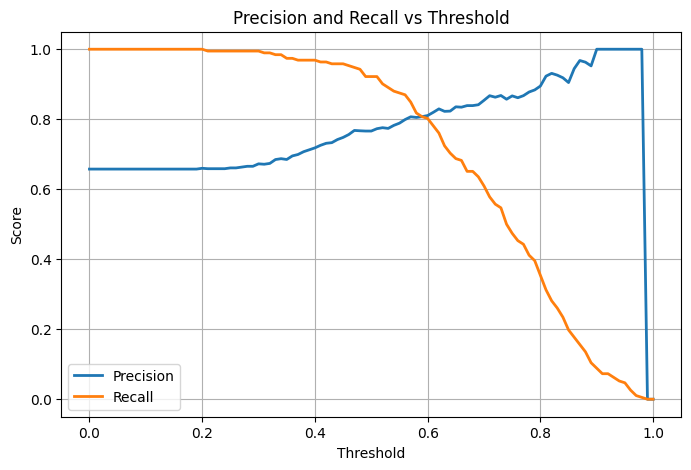

In [25]:
# Plot curves
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', lw=2)
plt.plot(thresholds, recalls, label='Recall', lw=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()



In [26]:
# Find intersection (closest point where Precision ≈ Recall)
diff = np.abs(np.array(precisions) - np.array(recalls))
intersection_index = diff.argmin()
intersection_threshold = thresholds[intersection_index]

print(f"📍 Precision ≈ Recall at threshold = {intersection_threshold:.3f}")

📍 Precision ≈ Recall at threshold = 0.590


In [27]:
# Initialize lists
precisions, recalls, f1_scores = [], [], []

# Compute P, R, F1 at each threshold
for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    P = precision_score(y_val, preds, zero_division=0)
    R = recall_score(y_val, preds, zero_division=0)
    F1 = 0 if (P + R) == 0 else 2 * P * R / (P + R)
    
    precisions.append(P)
    recalls.append(R)
    f1_scores.append(F1)



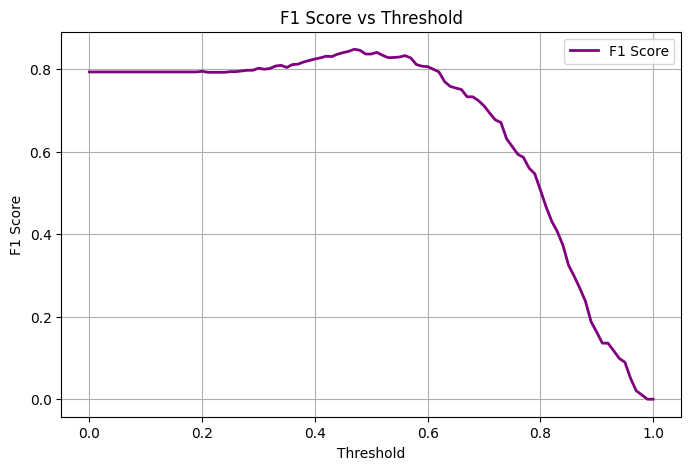

🏆 Best F1 = 0.848 at threshold = 0.470


In [28]:
# Find threshold with max F1
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

# Plot F1 curve
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple', lw=2)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

print(f"🏆 Best F1 = {best_f1:.3f} at threshold = {best_threshold:.3f}")

In [31]:
# ====================================================
# 5-Fold Cross Validation
# ====================================================
print("\n🔹 Performing 5-Fold Cross Validation...")

# Use the full training set (X_train, y_train)
train_full_dicts = X_train.to_dict(orient='records')
X_full = dv.fit_transform(train_full_dicts)
y_full = y_train.values

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full), 1):
    print(f"\n===== Fold {fold} =====")
    X_t, X_v = X_full[train_idx], X_full[val_idx]
    y_t, y_v = y_full[train_idx], y_full[val_idx]

    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_t, y_t)

    # Predict probabilities
    y_pred = model.predict_proba(X_v)[:, 1]

    # Compute AUC
    auc = roc_auc_score(y_v, y_pred)
    aucs.append(auc)
    print(f"AUC for Fold {fold}: {auc:.4f}")



🔹 Performing 5-Fold Cross Validation...

===== Fold 1 =====
AUC for Fold 1: 0.8117

===== Fold 2 =====
AUC for Fold 2: 0.8232

===== Fold 3 =====
AUC for Fold 3: 0.8364

===== Fold 4 =====
AUC for Fold 4: 0.8392

===== Fold 5 =====
AUC for Fold 5: 0.8283


In [32]:

# ====================================================
# Final Results
# ====================================================
print("\n🔹 Final Cross-Validation Results")
print("AUCs across folds:", np.round(aucs, 4))
print("Mean AUC:", np.mean(aucs).round(4))
print("Standard Deviation of AUC:", np.std(aucs).round(4))


🔹 Final Cross-Validation Results
AUCs across folds: [0.8117 0.8232 0.8364 0.8392 0.8283]
Mean AUC: 0.8278
Standard Deviation of AUC: 0.0098


In [33]:
print("\n🔹 Performing 5-Fold CV for Hyperparameter Tuning")

C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for C in C_values:
    print(f"\n===== Testing C = {C} =====")
    aucs = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_encoded), 1):
        X_t, X_v = X_train_encoded[train_idx], X_train_encoded[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_t, y_t)
        y_pred = model.predict_proba(X_v)[:, 1]
        
        auc = roc_auc_score(y_v, y_pred)
        aucs.append(auc)
        print(f"Fold {fold} AUC: {auc:.3f}")
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    results.append((C, round(mean_auc, 3), round(std_auc, 3)))



🔹 Performing 5-Fold CV for Hyperparameter Tuning

===== Testing C = 1e-06 =====


KeyError: '[6, 9, 10, 12, 27, 30, 35, 37, 41, 48, 51, 53, 58, 62, 67, 75, 76, 78, 80, 83, 87, 88, 91, 98, 99, 104, 108, 115, 125, 126, 131, 133, 134, 135, 139, 140, 142, 156, 158, 159, 163, 165, 167, 169, 177, 180, 186, 188, 190, 191, 198, 200, 204, 207, 208, 211, 215, 220, 226, 227, 228, 231, 234, 236, 237, 239, 250, 258, 259, 260, 264, 267, 268, 270, 274, 275, 280, 283, 284, 288, 292, 299, 302, 303, 304, 306, 310, 311, 315, 321, 323, 325, 329, 330, 331, 335, 336, 345, 347, 348, 349, 350, 351, 375, 382, 383, 386, 390, 392, 393, 395, 399, 400, 401, 403, 404, 407, 409, 414, 418, 419, 421, 424, 426, 432, 442, 452, 453, 460, 462, 471, 473, 478, 480, 481, 487, 490, 491, 495, 503, 509, 512, 520, 521, 525, 527, 528, 529, 531, 534, 535, 536, 537, 538, 541, 547, 553, 556, 559, 561, 571, 572, 573, 575, 577, 579, 581, 584, 587, 593, 597, 598, 599, 614, 620, 622, 628, 632, 638, 639, 647, 653, 654, 659, 660, 661, 663, 664, 674, 675, 679, 680, 693, 694, 697, 708, 709, 713, 718, 720, 724, 725, 729, 731, 735, 736, 737, 742, 745, 746, 748, 752, 754, 755, 757, 763, 764, 765, 767, 768, 771, 772, 776, 777, 778, 782, 785, 786, 798, 809, 810, 812, 815, 819, 820, 821, 823, 824, 826, 827, 830, 833, 841, 845, 846, 851, 852, 853, 855, 859, 860, 864, 867, 872, 876] not in index'

In [ ]:
print("\n🔹 Summary of Results:")
for C, mean_auc, std_auc in results:
    print(f"C={C:<10} | Mean AUC={mean_auc:.3f} | Std={std_auc:.3f}")

# Find best C
sorted_results = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C, best_mean, best_std = sorted_results[0]

print(f"\n🏆 Best C: {best_C}  (Mean AUC={best_mean:.3f}, Std={best_std:.3f})")